In [2]:
import gymnasium as gym
import gym_donkeycar

import os
from ruamel.yaml import YAML
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

from PIL import Image
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

from networks.utils import to_np, load_config, save_image_and_reconstruction

# custom classes and functions
from networks.blocks import ConvBlock, CategoricalStraightThrough
from networks.rssm import RSSM
from networks.mlp import MLP
from networks.categorical_vae import CategoricalVAE
from networks.actor_critic import ContinuousActorCritic
from preprocessing import grayscale_transform as transform

torch.cuda.empty_cache()
%matplotlib inline

## Load Hyperparameters from YAML config

In [3]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 2, 'Z': 1024, 'debug': False, 'logdir': 'logs/', 'seed': 0, 'size': [128, 128], 'grayscale': True, 'toy_env': False, 'n_episodes': 5000, 'max_episode_steps': 100, 'env_id': 'donkey-minimonaco-track-v0', 'max_grad_norm': 100, 'batch_size': 8, 'H': 512, 'num_categoricals': 32, 'num_classes': 32, 'mlp_n_layers': 3, 'mlp_hidden_dims': 256, 'action_clip_min': -1, 'action_clip_max': 1}


## Init Networks

In [4]:
rssm = RSSM().to(device)

rssm_optim = optim.Adam(
    rssm.parameters(), 
    lr=1e-4,

    # l2 regularizer
    weight_decay=1e-6, 
)

value_net = MLP(input_dims=Z, output_dims=1).to(device) # state (H+Z) -> 1
policy_net = MLP(input_dims=Z, output_dims=A, out_type="gaussian").to(device) # state (H+Z) -> A

Initializing encoder:
- adding ConvBlock((1, 32))                   ==> output shape: (32, 64, 64) ==> prod: 131072
- adding ConvBlock((32, 64))                   ==> output shape: (64, 32, 32) ==> prod: 65536
- adding ConvBlock((64, 128))                   ==> output shape: (128, 16, 16) ==> prod: 32768
- adding ConvBlock((128, 256))                   ==> output shape: (256, 8, 8) ==> prod: 16384
- adding ConvBlock((256, 64))                   ==> output shape: (64, 4, 4) ==> prod: 1024
- adding Flatten()
- adding Reshape: (*,1024) => (*,32,32)

Initializing decoder:
- adding Reshape: (*,1024) => (*,64,4,4)
- adding transpose ConvBlock(64, 64)                   ==> output shape: (64, 8, 8) ==> prod: 4096
- adding transpose ConvBlock(64, 256)                   ==> output shape: (256, 16, 16) ==> prod: 65536
- adding transpose ConvBlock(256, 128)                   ==> output shape: (128, 32, 32) ==> prod: 131072
- adding transpose ConvBlock(128, 64)                   ==> output shape: (

## Training loop

Notes:
- currently taking random actions (not the output of the actor)

In [6]:
""" training loop """

rssm.train()

# Create the environment
if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=100, render_mode="rgb_array") # rgb_array/human # 50 steps
else:
    assert A==2
    sim_config = {
        "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
        "port" : 9091
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id=env_id,
        max_episode_steps=max_episode_steps,
        make_kwargs={
            "conf": sim_config
        })

# Logging
log_dir = "logs/"
writer = SummaryWriter(log_dir)
notebook.start(f"--logdir={log_dir}")

episode_losses = { # for loss plots
    "episode_loss": [],
    "episode_image_loss": [],
    "episode_reward_loss": [],
    "episode_continue_loss": [],
    "episode_dyn_loss": [],
    "episode_rep_loss": [],
}

try:
    for episode in tqdm(range(n_episodes)):

        # Get the initial state
        obs, info = env.reset()

        # Reset the RNN's hidden state
        h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H

        # Add a new loss for the current episode and initialize it to 0
        episode_length = 0
        for key in episode_losses:
            episode_losses[key].append(torch.tensor(0, device=device, dtype=torch.float32))

        # Play one episode
        done = False
        while not done:

            x = transform(obs).view(-1, 1, 128, 128)

            """ WORLD MODEL LEARNING """

            # predict z and generate the true stochastic latent variable z with the encoder
            z_prior = rssm.dynamics_mlp(h).view(-1, num_categoricals, num_classes) # (1,32,32) for the softmax
            z_prior = F.softmax(z_prior, -1).flatten(start_dim=1, end_dim=2) # (1, 1024)
            z = rssm.vae.encode(x).flatten(start_dim=1, end_dim=2)

            # apply external actor and critic nets on z
            action_mean, action_var = policy_net(z)
            action = torch.normal(mean=action_mean, std=torch.sqrt(action_var)) # # Ax1 vector
            action = torch.clip(action, action_clip_min, action_clip_max)

            v = value_net(z)

            # predict one step using the RSSM
            h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)

            # choose and execute an action
            next_obs, reward, terminated, truncated, info = env.step(to_np(action.squeeze()))        

            done = terminated or truncated
            obs = next_obs

            # calculate the loss
            continue_target = torch.tensor(1 - done, device=device, dtype=torch.float32)
            reward = torch.tensor(reward, device=device, dtype=torch.float32)
            losses = rssm.get_losses(x, x_pred, reward, reward_pred, 
                                     continue_target, continue_prob, z_prior, z)

            # Add loss for the current step to the episode loss
            episode_length += 1
            for key in losses:
                episode_losses["episode_" + key][-1] += losses[key]

        # Calculate the mean loss of the episode
        for key in episode_losses:
            episode_losses[key][-1] /= episode_length

        # update the world model at the end of an episode using the mean loss of the episode
        rssm_optim.zero_grad()
        episode_losses["episode_loss"][-1].backward()
        nn.utils.clip_grad_norm_(rssm.vae.parameters(), max_norm=100.0, norm_type=2)  
        rssm_optim.step()

        # Detach the losses to save memory and log them in TensorBoard
        for key in episode_losses:
            episode_losses[key][-1] = episode_losses[key][-1].detach().item()
            writer.add_scalar(key, episode_losses[key][-1], global_step=episode)
        
        # save original image and reconstruction
        if episode % 10 == 0:
            save_image_and_reconstruction(x, x_pred, episode)

    env.close()

except KeyboardInterrupt:
    """ Clean handling for interrupts to stop training early """
    print("Stopping training.")
    # Delete the last loss if the training was stopped early
    # so that the list only consists of floats
    for key in episode_losses:
        if isinstance(episode_losses[key][-1], torch.Tensor):
            episode_losses[key] = episode_losses[key][:-1]

    # Close the TensorBoard writer and the gym environment
    writer.close()
    env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


  0%|                                                                                                  | 0/5000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  2%|█▍                                                                                     | 85/5000 [09:19<8:59:03,  6.58s/it]

Stopping training.
closing donkey sim subprocess


## Imagine

In [8]:
""" imagine n steps """

def imagine_n_steps(obs, n, save_images=False):

    if save_images:
        images = []

    # reset h
    h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device)

    # encode the first state
    x = transform(obs).view(-1, 1, 128, 128)
    z = rssm.vae.encode(x).flatten(start_dim=1, end_dim=2)


    for imagination_step in range(50):

        # predict z from h
        z_prior = rssm.dynamics_mlp(h).view(-1, num_categoricals, num_classes) # (1,32,32) for the softmax
        z_prior = F.softmax(z_prior, -1).flatten(start_dim=1, end_dim=2) # (1, 1024)
        z = z_prior

        # sample an action
        action_mean, action_var = policy_net(z)
        action = torch.normal(mean=action_mean, std=torch.sqrt(action_var)) # Ax1 vector
        action = torch.clip(action, action_clip_min, action_clip_max)

        # predict the value
        v = value_net(z)

        # predict one step using the RSSM
        h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)
        done = 1 - continue_pred

        if save_images:
            images.append((255 * to_np(x_pred[0][0])).astype("uint8"))

    if save_images:
        imageio.mimsave("reconstructions/imagined_episode.gif", images, duration=0.03)

In [11]:
if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=100, render_mode="rgb_array") # rgb_array/human # 50 steps
else:
    assert A==2
    sim_config = {
        "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
        "port" : 9091
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id=env_id,
        max_episode_steps=max_episode_steps,
        make_kwargs={
            "conf": sim_config
        })
obs, info = env.reset()

imagine_n_steps(obs, 100, save_images=True)

env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


In [ ]:
# GPU memory consumption:
# 10 steps -> 6504MiB
# 50 steps -> 19990MiB

## Plot results

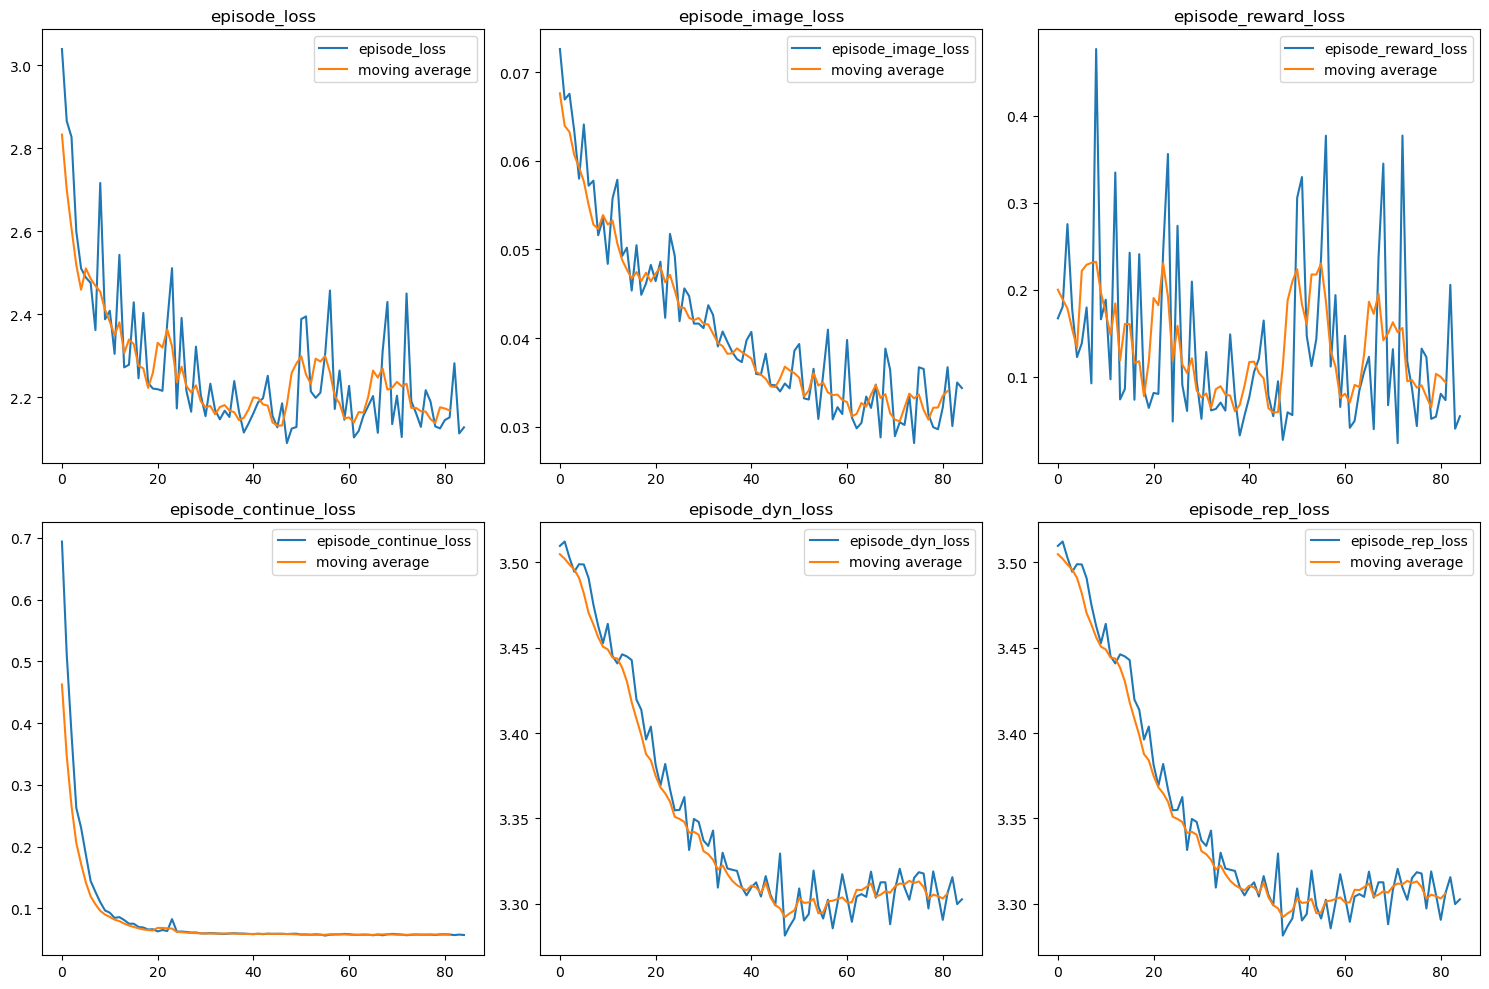

In [7]:
rolling_length = max(1, int(len(episode_losses["episode_loss"])/20))

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*5, 2*5))

# Iterate over the keys and plot the losses
for i, key in enumerate(episode_losses.keys()):
    row = i // 3
    col = i % 3

    axs[row, col].set_title(key)
    losses = episode_losses[key]
    losses_moving_average = (
        np.convolve(
            np.array(losses).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[row, col].plot(range(len(losses)), losses, label=key)
    axs[row, col].plot(range(len(losses_moving_average)), losses_moving_average, label="moving average")
    axs[row, col].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Test area

In [ ]:
""" save reconstructions for one episode """

save_one_episode = False


if save_one_episode:
    rssm.eval()

    # Create the environment
    if toy_env:
        assert A==3
        env = gym.make("CarRacing-v2", max_episode_steps=150, render_mode="rgb_array") # rgb_array/human # 50 steps
    else:
        assert A==2
        sim_config = {
            "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
            "port" : 9091
        }
        env = gym.make(
            "GymV21Environment-v0", 
            env_id=env_id,
            max_episode_steps=max_episode_steps,
            make_kwargs={
                "conf": sim_config
            })


    try:
        for episode in tqdm(range(1)):

            # Get the initial state
            obs, info = env.reset()

            # Reset the RNN's hidden state
            h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H

            # Add a new loss for the current episode and initialize it to 0
            episode_length = 0

            # Play one episode
            done = False
            while not done:

                x = transform(obs).view(-1, 1, 128, 128)

                """ WORLD MODEL LEARNING """

                # predict z and generate the true stochastic latent variable z with the encoder
                z_prior = rssm.dynamics_mlp(h).view(-1, num_categoricals, num_classes) # (1,32,32) for the softmax
                z_prior = F.softmax(z_prior, -1).flatten(start_dim=1, end_dim=2) # (1, 1024)
                z = rssm.vae.encode(x).flatten(start_dim=1, end_dim=2)

                # apply external actor and critic nets on z
                action = torch.tensor([(np.random.rand() - 0.5)/3, (np.random.rand() + 0.5)/3], device=device).unsqueeze(dim=0) # policy_net(z) # Ax1 vector
                v = value_net(z)

                # predict one step using the RSSM and apply the actor-critic
                h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)

                # choose and execute an action
                next_obs, reward, terminated, truncated, info = env.step(to_np(action.squeeze()))        

                done = terminated or truncated
                obs = next_obs

                # calculate the loss
                continue_target = torch.tensor(1 - done, device=device, dtype=torch.float32)
                reward = torch.tensor(reward, device=device, dtype=torch.float32)

                # TODO: z_prior, z_posterior
                z_prior = torch.tensor(0, device=device, dtype=torch.float32)
                z_posterior = torch.tensor(0, device=device, dtype=torch.float32)

                plt.imsave(f"reconstructions/{episode_length}.png", to_np(x_pred[0][0]), cmap="gray")
                episode_length += 1

        env.close()

    except KeyboardInterrupt:
        """ Clean handling for interrupts to stop training early """
        print("Stopping training.")
        # Delete the last loss if the training was stopped early
        # so that the list only consists of floats
        for key in episode_losses:
            if isinstance(episode_losses[key][-1], torch.Tensor):
                episode_losses[key] = episode_losses[key][:-1]

        # Close the TensorBoard writer and the gym environment
        writer.close()
        env.close()